<a href="https://colab.research.google.com/github/shirish-baral/deep-learning/blob/main/fetal_brain_ultrasound_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rahimalargo_fetalultrasoundbrain_path = kagglehub.dataset_download('rahimalargo/fetalultrasoundbrain')

print('Data source import complete.')


Data source import complete.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import shutil
import tqdm


Data Loading and Exploration

In [ ]:
print("--- Data Loading and Exploration ---")
# Use the path from kagglehub.dataset_download
metadata_train = pd.read_csv(os.path.join(rahimalargo_fetalultrasoundbrain_path, 'train.csv'))
metadata_test = pd.read_csv(os.path.join(rahimalargo_fetalultrasoundbrain_path, 'test.csv'))

print("Training DataFrame : \n")
print(metadata_train.info(), "\n")
with pd.option_context('display.max_rows', 5):
    display(metadata_train)

print("\n\n-------------------------------------\n\nTesting DataFrame :\n")
print(metadata_test.info(), "\n")
with pd.option_context('display.max_rows', 5):
    display(metadata_test)

# Update datapath to the correct location
datapath = os.path.join(rahimalargo_fetalultrasoundbrain_path, "data", "data")

--- Data Loading and Exploration ---
Training DataFrame : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  2500 non-null   object
 1   class       2500 non-null   object
dtypes: object(2)
memory usage: 39.2+ KB
None 



,image_name,class
0,Patient00168_Plane3_1_of_3,Trans-thalamic
1,Patient00168_Plane3_2_of_3,Trans-thalamic
...,...,...
2498,Patient01560_Plane3_4_of_4,Trans-thalamic
2499,Patient01562_Plane3_1_of_1,Trans-ventricular




-------------------------------------

Testing DataFrame :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  592 non-null    object 
 1   class       0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 9.4+ KB
None 



,image_name,class
0,Patient01563_Plane3_1_of_3,NaN
1,Patient01563_Plane3_2_of_3,NaN
...,...,...
590,Patient01791_Plane3_3_of_3,NaN
591,Patient01792_Plane3_1_of_1,NaN


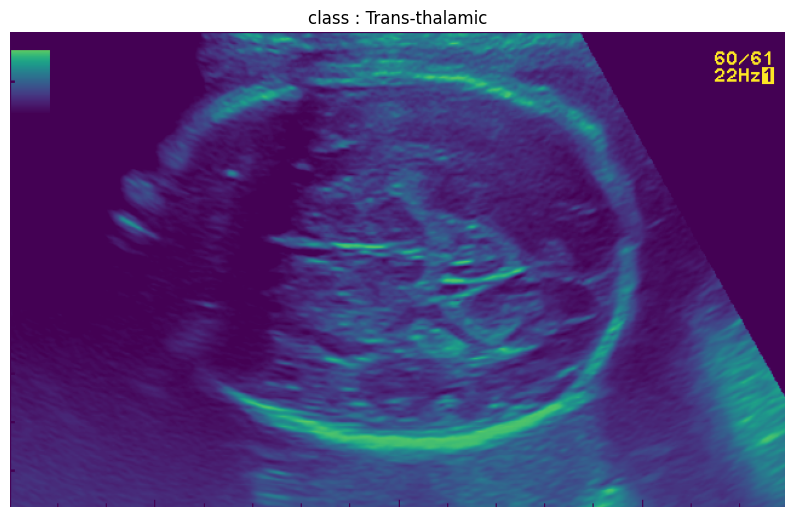

Sample image shape: (392, 640)


In [ ]:
# Display a sample image
img_sample_path = os.path.join(datapath, metadata_train.iloc[0]['image_name']) + ".png"
if os.path.exists(img_sample_path):
    img = plt.imread(img_sample_path)
    plt.figure(figsize=(10, 10))
    plt.title('class : ' + metadata_train.iloc[0]['class'])
    plt.imshow(img)
    plt.axis('off') # Hide axes for cleaner image display
    plt.show()
    print(f"Sample image shape: {img.shape}")
else:
    print(f"Sample image not found at {img_sample_path}")


In [ ]:
# --- 2. Data Preparation ---
print("\n--- Data Preparation ---")

X_train, X_valid = train_test_split(metadata_train, test_size=0.3, random_state=42)

classes_map = {
    'Trans-cerebellum': 0,
    'Trans-thalamic': 1,
    'Trans-ventricular': 2,
    'Other': 3
}


--- Data Preparation ---


In [ ]:
# Invert the map for later use in prediction
idx_to_class = {v: k for k, v in classes_map.items()}

out_dir = '/kaggle/working/out'
train_dir = os.path.join(out_dir, 'train')
test_dir = os.path.join(out_dir, 'test')
valid_dir = os.path.join(out_dir, 'valid')

In [ ]:
# Clean up previous runs
try:
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    print(f"Removed existing directory: {out_dir}")
except OSError as e:
    print(f"Error removing directory {out_dir}: {e.filename} - {e.strerror}")


Removed existing directory: /kaggle/working/out


In [ ]:
# Create base directories
try:
    os.makedirs(train_dir)
    os.makedirs(test_dir)
    os.makedirs(valid_dir)
    print("Created train, test, and valid base directories.")
except OSError as e:
    print(f"Error creating base directories: {e.filename} - {e.strerror}")

Created train, test, and valid base directories.


In [ ]:
# Create class subfolders for train and valid
for class_name in list(classes_map.keys()):
    try:
        os.makedirs(os.path.join(train_dir, class_name))
        os.makedirs(os.path.join(valid_dir, class_name))
        print(f"Created class subdirectories for {class_name} in train and valid.")
    except OSError as e:
        print(f"Error creating class subdirectories for {class_name}: {e.filename} - {e.strerror}")

Created class subdirectories for Trans-cerebellum in train and valid.
Created class subdirectories for Trans-thalamic in train and valid.
Created class subdirectories for Trans-ventricular in train and valid.
Created class subdirectories for Other in train and valid.


In [ ]:
# Copy images to their respective folders
print("Copying training images...")
for index_num, row in tqdm.tqdm(X_train.iterrows(), total=len(X_train)):
    filename = os.path.join(datapath, row['image_name'] + '.png')
    try:
        shutil.copy(filename, os.path.join(train_dir, row['class']))
    except FileNotFoundError:
        print(f"Warning: Image not found {filename}. Skipping.")
    except Exception as e:
        print(f"Error occurred while copying {filename} to train: {e}")

        print("Copying validation images...")
for index_num, row in tqdm.tqdm(X_valid.iterrows(), total=len(X_valid)):
    filename = os.path.join(datapath, row['image_name'] + '.png')
    try:
        shutil.copy(filename, os.path.join(valid_dir, row['class']))
    except FileNotFoundError:
        print(f"Warning: Image not found {filename}. Skipping.")
    except Exception as e:
        print(f"Error occurred while copying {filename} to valid: {e}")

print("Copying test images...")
for index_num, row in tqdm.tqdm(metadata_test.iterrows(), total=len(metadata_test)):
    filename = os.path.join(datapath, row['image_name'] + '.png')
    try:
        shutil.copy(filename, test_dir)
    except FileNotFoundError:
        print(f"Warning: Image not found {filename}. Skipping.")
    except Exception as e:
        print(f"Error occurred while copying {filename} to test: {e}")


Copying training images...


100%|██████████| 750/750 [00:04<00:00, 178.04it/s]


Copying test images...


100%|██████████| 592/592 [00:00<00:00, 766.42it/s]


# **3. Data Augmentation and Loaders (PyTorch)**

In [ ]:
print("\n--- Data Augmentation and Loaders ---")

# ImageNet normalization values
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize((300, 300)), # Resize all images to 300x300
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor
    normalize # Normalize with ImageNet stats
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    normalize
])


--- Data Augmentation and Loaders ---


In [ ]:
# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_test_transforms)

# --- Test Data Setup ---
# For the test set, ImageFolder expects subdirectories.
# Since we copied all test images directly into test_dir, we'll create a dummy
# subdirectory for ImageFolder to work correctly.

# Ensure test_dir is clean before setting up test data
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

dummy_test_subdir = os.path.join(test_dir, 'dummy_class')
os.makedirs(dummy_test_subdir) # Create the dummy subdirectory

# Copy test images from the original source to the dummy subdirectory
# Ensure datapath is accessible here. datapath is defined in Wnam5Fiv9FRX
# Assuming datapath is available from previous execution:
for index_num, row in metadata_test.iterrows():
    filename = os.path.join(datapath, row['image_name'] + '.png')
    try:
        shutil.copy(filename, dummy_test_subdir)
    except FileNotFoundError:
        print(f"Warning: Image not found {filename}. Skipping.")
    except Exception as e:
        print(f"Error occurred while copying {filename} to dummy test dir: {e}")

# Point ImageFolder to the parent directory of the dummy class
test_dataset = datasets.ImageFolder(test_dir, transform=valid_test_transforms)

# Create DataLoaders (ensure this section is still here)
# BATCH_SIZE is defined in HBsEYtxr-VPQ, num_workers in HBsEYtxr-VPQ
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2) # Batch size 1 for predictions

# print(f"Train dataset size: {len(train_dataset)}")
# print(f"Validation dataset size: {len(valid_dataset)}")
# print(f"Test dataset size: {len(test_dataset)}")
# print(f"Class indices from train_dataset: {train_dataset.class_to_idx}")

In [ ]:
# Create DataLoaders
BATCH_SIZE = 100 # From Keras notebook
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2) # Batch size 1 for predictions

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Class indices from train_dataset: {train_dataset.class_to_idx}")

Train dataset size: 1750
Validation dataset size: 750
Test dataset size: 592
Class indices from train_dataset: {'Other': 0, 'Trans-cerebellum': 1, 'Trans-thalamic': 2, 'Trans-ventricular': 3}


# **4. Model Definition (PyTorch)**

In [ ]:
print("\n--- Model Definition ---")

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ResNeXt50
model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V1)

# Freeze all parameters in the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier head
num_ftrs = model.fc.in_features # Get the number of input features to the final layer
model.fc = nn.Linear(num_ftrs, len(classes_map)) # Our 4 classes

model = model.to(device)

print(model)


--- Model Definition ---
Using device: cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential

# 5. Training Loop (PyTorch)**bold text**

In [ ]:
print("\n--- Training Loop ---")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters()) # Only optimize the new classifier head

# Training history for plotting
history = {
    'loss': [],
    'val_loss': [],
    'categorical_accuracy': [],
    'val_categorical_accuracy': []
}

early_stopping_patience = 5
min_delta = 0.001
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = None

num_epochs = 50 # From Keras notebook

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in tqdm.tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # Zero the parameter gradients

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['categorical_accuracy'].append(epoch_accuracy)

    # Validation phase
    model.eval() # Set model to evaluate mode
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in tqdm.tqdm(valid_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(valid_dataset)
    val_epoch_accuracy = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_categorical_accuracy'].append(val_epoch_accuracy)

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f} | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_accuracy:.4f}")

    # # Early stopping logic
    # if val_epoch_loss < best_val_loss - min_delta:
    #     best_val_loss = val_epoch_loss
    #     epochs_no_improve = 0
    #     best_model_wts = model.state_dict() # Save best model weights
    #     print(f"Validation loss improved to {best_val_loss:.4f}. Saving model weights.")
    # else:
    #     epochs_no_improve += 1
    #     print(f"Validation loss did not improve. Epochs with no improvement: {epochs_no_improve}")
    #     if epochs_no_improve >= early_stopping_patience:
    #         print(f"Early stopping triggered after {epoch + 1} epochs.")
    #         break




--- Training Loop ---
Epoch 1/50


Validation: 100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


Train Loss: 1.1460 Acc: 0.5440 | Val Loss: 1.2034 Acc: 0.4773
Epoch 2/50


Validation: 100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


Train Loss: 1.0645 Acc: 0.5571 | Val Loss: 1.1161 Acc: 0.4707
Epoch 3/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


Train Loss: 1.0334 Acc: 0.5686 | Val Loss: 1.1252 Acc: 0.4533
Epoch 4/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Train Loss: 1.0157 Acc: 0.5697 | Val Loss: 1.1059 Acc: 0.4893
Epoch 5/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


Train Loss: 1.0058 Acc: 0.5811 | Val Loss: 1.1072 Acc: 0.4747
Epoch 6/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Train Loss: 0.9908 Acc: 0.5766 | Val Loss: 1.0228 Acc: 0.5573
Epoch 7/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Train Loss: 0.9626 Acc: 0.6011 | Val Loss: 1.0716 Acc: 0.5120
Epoch 8/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


Train Loss: 0.9637 Acc: 0.6057 | Val Loss: 1.0122 Acc: 0.5427
Epoch 9/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.61s/it]


Train Loss: 0.9432 Acc: 0.6040 | Val Loss: 1.0041 Acc: 0.5573
Epoch 10/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


Train Loss: 0.9428 Acc: 0.5937 | Val Loss: 0.9899 Acc: 0.5707
Epoch 11/50


Validation: 100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


Train Loss: 0.9404 Acc: 0.5954 | Val Loss: 1.0391 Acc: 0.5373
Epoch 12/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Train Loss: 0.9151 Acc: 0.6183 | Val Loss: 1.0520 Acc: 0.5333
Epoch 13/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


Train Loss: 0.9398 Acc: 0.6154 | Val Loss: 1.0999 Acc: 0.5080
Epoch 14/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


Train Loss: 0.9332 Acc: 0.5971 | Val Loss: 0.9697 Acc: 0.5773
Epoch 15/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


Train Loss: 0.8993 Acc: 0.6246 | Val Loss: 0.9870 Acc: 0.5693
Epoch 16/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Train Loss: 0.8904 Acc: 0.6343 | Val Loss: 0.9834 Acc: 0.5707
Epoch 17/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Train Loss: 0.8971 Acc: 0.6240 | Val Loss: 1.0018 Acc: 0.5627
Epoch 18/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Train Loss: 0.8914 Acc: 0.6337 | Val Loss: 0.9611 Acc: 0.5827
Epoch 19/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


Train Loss: 0.8762 Acc: 0.6326 | Val Loss: 0.9614 Acc: 0.5853
Epoch 20/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.61s/it]


Train Loss: 0.8637 Acc: 0.6417 | Val Loss: 0.9446 Acc: 0.5907
Epoch 21/50


Validation: 100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


Train Loss: 0.8665 Acc: 0.6331 | Val Loss: 0.9804 Acc: 0.5773
Epoch 22/50


Validation: 100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


Train Loss: 0.8741 Acc: 0.6269 | Val Loss: 0.9977 Acc: 0.5507
Epoch 23/50


Validation: 100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


Train Loss: 0.8762 Acc: 0.6286 | Val Loss: 0.9506 Acc: 0.5933
Epoch 24/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


Train Loss: 0.8741 Acc: 0.6354 | Val Loss: 0.9456 Acc: 0.5880
Epoch 25/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


Train Loss: 0.8780 Acc: 0.6314 | Val Loss: 0.9631 Acc: 0.5733
Epoch 26/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Train Loss: 0.8668 Acc: 0.6451 | Val Loss: 0.9840 Acc: 0.5520
Epoch 27/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


Train Loss: 0.8722 Acc: 0.6291 | Val Loss: 0.9713 Acc: 0.5707
Epoch 28/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Train Loss: 0.8524 Acc: 0.6446 | Val Loss: 0.9862 Acc: 0.5840
Epoch 29/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


Train Loss: 0.8570 Acc: 0.6434 | Val Loss: 0.9385 Acc: 0.5907
Epoch 30/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Train Loss: 0.8282 Acc: 0.6611 | Val Loss: 0.9402 Acc: 0.5867
Epoch 31/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Train Loss: 0.8459 Acc: 0.6394 | Val Loss: 0.9372 Acc: 0.5827
Epoch 32/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.53s/it]


Train Loss: 0.8577 Acc: 0.6400 | Val Loss: 0.9543 Acc: 0.5840
Epoch 33/50


Validation: 100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


Train Loss: 0.8476 Acc: 0.6566 | Val Loss: 0.9533 Acc: 0.5987
Epoch 34/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Train Loss: 0.8205 Acc: 0.6497 | Val Loss: 0.9464 Acc: 0.5973
Epoch 35/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


Train Loss: 0.8486 Acc: 0.6320 | Val Loss: 1.0585 Acc: 0.5493
Epoch 36/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


Train Loss: 0.8463 Acc: 0.6457 | Val Loss: 0.9376 Acc: 0.5987
Epoch 37/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Train Loss: 0.8290 Acc: 0.6594 | Val Loss: 0.9359 Acc: 0.5947
Epoch 38/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Train Loss: 0.8280 Acc: 0.6611 | Val Loss: 0.9389 Acc: 0.6053
Epoch 39/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


Train Loss: 0.8132 Acc: 0.6663 | Val Loss: 0.9175 Acc: 0.6107
Epoch 40/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


Train Loss: 0.8179 Acc: 0.6669 | Val Loss: 0.9182 Acc: 0.5960
Epoch 41/50


Validation: 100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


Train Loss: 0.8128 Acc: 0.6543 | Val Loss: 0.9366 Acc: 0.5880
Epoch 42/50


Validation: 100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


Train Loss: 0.8363 Acc: 0.6566 | Val Loss: 0.9274 Acc: 0.5987
Epoch 43/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


Train Loss: 0.8277 Acc: 0.6589 | Val Loss: 0.9373 Acc: 0.5907
Epoch 44/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Train Loss: 0.8132 Acc: 0.6651 | Val Loss: 0.9183 Acc: 0.6013
Epoch 45/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


Train Loss: 0.8151 Acc: 0.6589 | Val Loss: 0.9295 Acc: 0.5933
Epoch 46/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


Train Loss: 0.8254 Acc: 0.6526 | Val Loss: 0.9305 Acc: 0.6000
Epoch 47/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Train Loss: 0.8359 Acc: 0.6589 | Val Loss: 0.9457 Acc: 0.5760
Epoch 48/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


Train Loss: 0.8233 Acc: 0.6503 | Val Loss: 0.9447 Acc: 0.5800
Epoch 49/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


Train Loss: 0.8121 Acc: 0.6691 | Val Loss: 0.9283 Acc: 0.6093
Epoch 50/50


Validation: 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]

Train Loss: 0.8109 Acc: 0.6600 | Val Loss: 0.9232 Acc: 0.5960


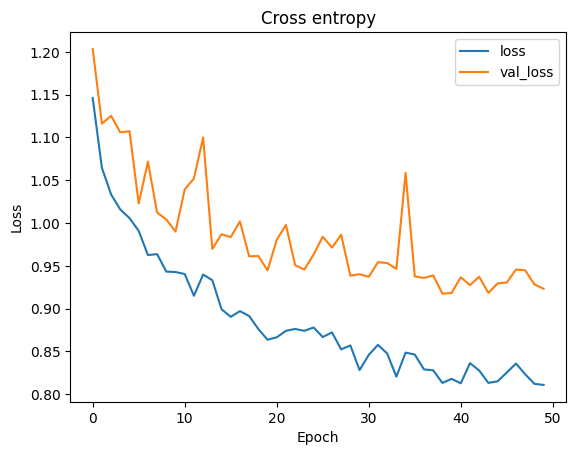

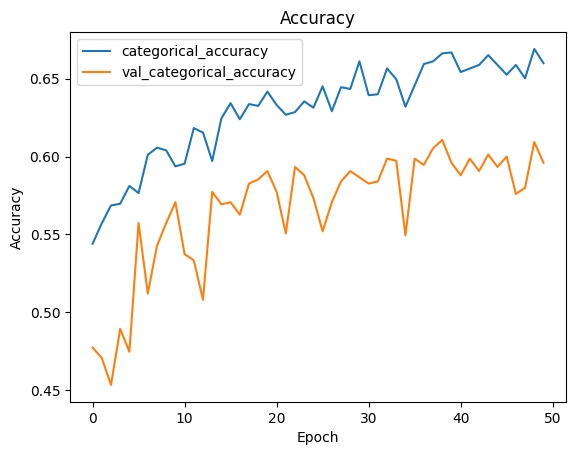

In [ ]:
# Restore best model weights if early stopping occurred
if best_model_wts:
    model.load_state_dict(best_model_wts)
    print("Restored best model weights.")

# Plotting history
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross entropy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot(title="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


# **6. Prediction**

In [ ]:
print("\n--- Prediction ---")

model.eval() # Set model to evaluation mode
all_preds = []
# Get original filenames from the dummy test subdirectory
test_filenames = [os.path.basename(path) for path, _ in test_dataset.samples]

with torch.no_grad():
    for inputs, _ in tqdm.tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        pred_idx = predicted.item() # Get the predicted index
        # print(f"Predicted index: {pred_idx}") # Debug print - can be removed now
        all_preds.append(pred_idx)

# Map numerical predictions back to class names
# Adjust mapping because ImageFolder will see 'dummy_class' as index 0
# We need to map the predicted index from the model (which corresponds to our original classes_map)
# to the correct class name. The model's output layer size is based on classes_map.
# The predicted index from the model will be one of 0, 1, 2, 3 corresponding to our original classes.
predicted_class_names = [idx_to_class[p] for p in all_preds]


# Prepare submission dataframe
submission = pd.DataFrame({
    'image_name': [f.replace('.png', '') for f in test_filenames], # Remove .png extension
    'class': predicted_class_names
})

print("\nSubmission Head:")
print(submission.head())

# Save submission file
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("\nSubmission file saved to /kaggle/working/submission.csv")

# Clean up dummy test subdirectory AFTER prediction
if os.path.exists(dummy_test_subdir):
    # Remove the dummy subdirectory and its contents
    shutil.rmtree(dummy_test_subdir)
    print(f"Cleaned up dummy test subdirectory: {dummy_test_subdir}")


--- Prediction ---


Predicting: 100%|██████████| 592/592 [00:13<00:00, 42.37it/s]


Submission Head:
                   image_name           class
0  Patient01563_Plane3_1_of_3  Trans-thalamic
1  Patient01563_Plane3_2_of_3  Trans-thalamic
2  Patient01563_Plane3_3_of_3           Other
3  Patient01564_Plane3_1_of_2           Other
4  Patient01564_Plane3_2_of_2           Other

Submission file saved to /kaggle/working/submission.csv
Cleaned up dummy test subdirectory: /kaggle/working/out/test/dummy_class


In [ ]:
# Invert the map for later use in prediction
idx_to_class = {v: k for k, v in classes_map.items()}

out_dir = '/kaggle/working/out'
train_dir = os.path.join(out_dir, 'train')
test_dir = os.path.join(out_dir, 'test')
valid_dir = os.path.join(out_dir, 'valid')

In [ ]:
display(submission.head())

,image_name,class
0,Patient01563_Plane3_1_of_3,Trans-thalamic
1,Patient01563_Plane3_2_of_3,Trans-thalamic
2,Patient01563_Plane3_3_of_3,Other
3,Patient01564_Plane3_1_of_2,Other
4,Patient01564_Plane3_2_of_2,Other
